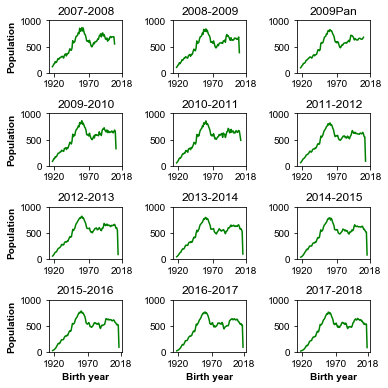

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import pandas as pd
from scipy.interpolate import splev, splrep
import numpy as np
from matplotlib import rcParams, colors
import seaborn as sns
%matplotlib inline

rcParams['font.sans-serif'] = 'arial'

demodf = pd.read_csv('../data/demography_by_birth_year.csv')

subplot = 1
for season, df in demodf.groupby('Season'):

    if season >= 2008:
        plt.subplot(4,3,subplot)
        
        plotdf = df.sort_values('Birth_year').copy()
        plt.plot(plotdf['Birth_year'], plotdf['Population'], '-', color='green')
        plt.xticks([1920, 1970, 2018])
        plt.ylim(0, 1000)
        
        
        if season != 2009.5:
            plt.title(str(int(season) - 1) + '-' + str(int(season)))
        else:
            plt.title('2009Pan')
            
        if subplot in [10, 11, 12]:
            plt.xlabel('Birth year', weight='bold')
        else:
            plt.xlabel('')
        if subplot in [1, 4, 7, 10]:
            plt.ylabel('Population', weight='bold')
        else:
            plt.ylabel('')
        subplot += 1
plt.gcf().set_size_inches(5.5, 5.5)
plt.tight_layout()

C:\Users\parevalo\Miniconda3\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



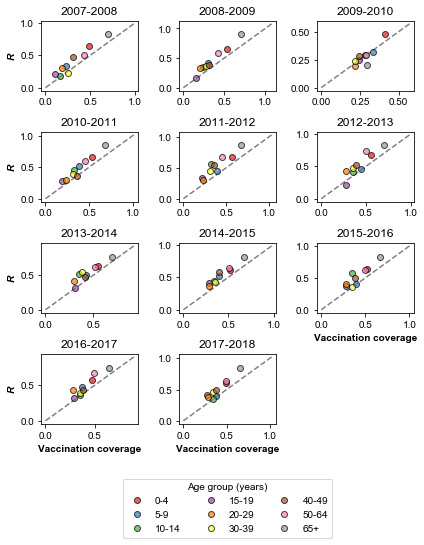

In [2]:
def age_to_age_class(age):
    for l, u in age_classes:
        if age <= u and age >= l:
            age_class = '-'.join([str(l), str(u)])
            break
    if age_class == '65-200':
        age_class = '65-100'
    return age_class


vac_counts = pd.read_csv('../raw_data/monovalent_vaccination_counts.csv')
demo_data = pd.read_csv('../data/demography_by_age_extended.csv')
df_c = pd.read_csv('../raw_data/vac_coverage_by_age_seasonal_2010.csv')
tn_data = pd.read_csv('../raw_data/test-negative_vac_status.csv')

age_classes = [(0, 4),
               (5, 9),
               (10, 14),
               (15, 19),
               (20, 29),
               (30, 39),
               (40, 49),
               (50, 64),
               (65, 200)]

spl = splrep(vac_counts.age, vac_counts.Coverage, s=5)
interp = splev(range(0, max(vac_counts.age) + 1), spl)
mono_cov = demo_data[(demo_data.Season == 2009.5) &
                      (demo_data.Age <= max(vac_counts.age))].copy()
mono_cov['Vaccinated'] = mono_cov.Population * interp
mono_cov['Unvaccinated'] = mono_cov.Population - mono_cov.Vaccinated
mono_cov['coverage'] = interp
mono_cov['Season'] = '2010'
mono_cov = mono_cov[['Age', 'Season', 'coverage', 'Vaccinated', 'Unvaccinated']]


df_c = df_c[df_c.Season != 2010]
df_c = pd.concat([df_c, mono_cov])
df_c['age_group'] = df_c.Age.apply(age_to_age_class)
df_c = df_c.groupby(['Season', 'age_group']).sum().reset_index()
df_c['coverage'] = df_c.Vaccinated / (df_c.Vaccinated + df_c.Unvaccinated)
df_c = df_c[['Season', 'age_group', 'coverage']]
df_c['Season'] = df_c.Season.astype(float)



combined = tn_data.merge(df_c, on=['Season', 'age_group'])


pal = sns.color_palette('Set1', 9).as_hex()
subplot = 1
for season, seasondf in combined.groupby('Season'):
    plt.subplot(4, 3, subplot)
    plotdf = seasondf.copy()
    plotdf.index = plotdf.age_group
    plotdf = plotdf.loc[[age_to_age_class(l) for l,u in age_classes], ]
    maxc = plotdf.max().coverage
    maxv = plotdf.max().V_factor

    
    max_coord = 1.2 * maxv
    
    i = 0
    plt.plot([0, max_coord], [0, max_coord], '--', color='grey')
    for age_group, row in plotdf.iterrows():
        if age_group == '65-100':
            label = '65+'
        else:
            label = age_group
        plt.plot([row.coverage],
                 [row.V_factor],
                 'o', color= pal[i],
                 label=label,
                 markeredgecolor='k',
                 markersize=6,
                 alpha=0.7)
        i+=1
    

    plt.title(str(season - 1) + '-' + str(season))
    
    if subplot in [1,4,7,10]:
        plt.ylabel('R', weight='bold', style='italic')
    if subplot in [9, 10, 11]:
        plt.xlabel('Vaccination coverage', weight='bold')
    subplot += 1
plt.gcf().set_size_inches(6, 6.5)
plt.tight_layout()
plt.legend(ncol=3, title='Age group (years)', loc='center', bbox_to_anchor=(0.5, -1.2))


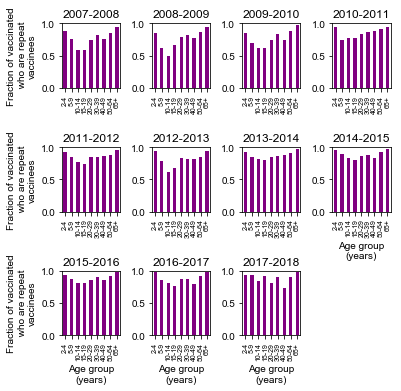

In [3]:
plotdf = pd.read_csv('../raw_data/repeat_vaccination.csv')

subplot = 1
new_labels = ['2-4',
              '5-9',
              '10-14',
              '15-19',
              '20-29',
              '30-39',
              '40-49',
              '50-64',
              '65+']

for season, seasondf in plotdf.groupby('Season'):
    if season != '2009Pan':
        plt.subplot(3, 4, subplot)
        ax = plt.gca()
        seasondf.plot.bar(x='Age group', y='Fraction repeat vaccinees', ax=ax, color='purple', legend=False)
        plt.ylim(0, 1)
        plt.title(str(int(season) - 1) + '-' + str(season))
        if subplot >= 8:
            ticks, labels = plt.xticks()
            plt.xticks(ticks, new_labels, size=7)
            plt.xlabel('Age group\n(years)')
        else:
            ticks, labels = plt.xticks()
            plt.xticks(ticks, new_labels, size=7)
            plt.xlabel('')
            
        if subplot in (1,5,9):
            plt.ylabel('Fraction of vaccinated\n who are repeat\nvaccinees')
        subplot += 1  
plt.gcf().set_size_inches(5.75, 5.5)
plt.tight_layout(w_pad = 0.2)